In [4]:
import ember
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

emberData = "C:\\Users\\cosbyd\\OneDrive - purdue.edu\\Documents\\ember2018"

In [5]:
#create the train/test split (change PATH to where teh ember2018 file is stored tho)
#returns 4 np array (x/y  train and x/y test)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(emberData)

In [6]:
#filter out any data that has a label of -1. These are the files that aren't classified where 0/1 is using to say if its either benign or malware
train_rows = (y_train != -1)
X = X_train[train_rows]
Y = y_train[train_rows]

#Normalize data between 0-1 for better output
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)

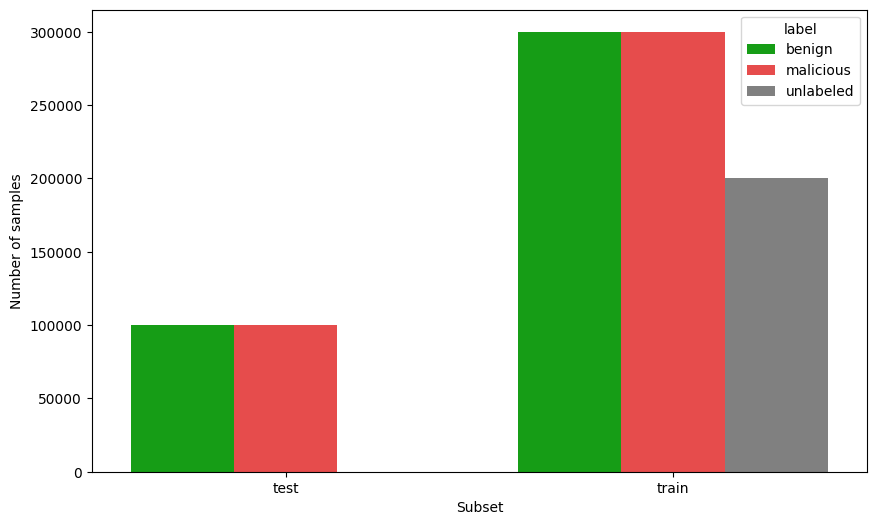

In [4]:
emberdf = ember.read_metadata(emberData)
plotdf = emberdf.copy()
plotdf['label'] = plotdf['label'].map({-1: 'unlabeled', 0: 'benign', 1: 'malicious'})
gbdf = plotdf.groupby(["label", "subset"]).count().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='subset', y='sha256', hue='label', data=gbdf, palette=["#00b300", "#ff3333", "#808080"])
plt.xlabel('Subset')
plt.ylabel('Number of samples')
plt.show()

In [5]:
#define model architecture 
model = models.Sequential()
model.add(layers.Dense(2400, activation='relu', input_dim=2381))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1200, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1200, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

#compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2400)              5716800   
                                                                 
 dropout (Dropout)           (None, 2400)              0         
                                                                 
 dense_1 (Dense)             (None, 1200)              2881200   
                                                                 
 dropout_1 (Dropout)         (None, 1200)              0         
                                                                 
 dense_2 (Dense)             (None, 1200)              1441200   
                                                                 
 dense_3 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 10,040,401
Trainable params: 10,040,401
No

In [6]:
#train model for 20 epochs
model.fit(x=X_scaled, y=Y, batch_size=128, epochs=10, verbose=1, shuffle=True, validation_split = 0.01) 
(print)

Epoch 1/10
4641/4641 [==============================] - 462s 99ms/step - loss: 0.1972 - accuracy: 0.9205 - val_loss: 0.1347 - val_accuracy: 0.9422
Epoch 2/10
4641/4641 [==============================] - 450s 97ms/step - loss: 0.1462 - accuracy: 0.9424 - val_loss: 0.1047 - val_accuracy: 0.9538
Epoch 3/10
4641/4641 [==============================] - 449s 97ms/step - loss: 0.1248 - accuracy: 0.9507 - val_loss: 0.1054 - val_accuracy: 0.9630
Epoch 4/10
4641/4641 [==============================] - 451s 97ms/step - loss: 0.1128 - accuracy: 0.9552 - val_loss: 0.0915 - val_accuracy: 0.9703
Epoch 5/10
4641/4641 [==============================] - 450s 97ms/step - loss: 0.1047 - accuracy: 0.9584 - val_loss: 0.0885 - val_accuracy: 0.9697
Epoch 6/10
4641/4641 [==============================] - 450s 97ms/step - loss: 0.1000 - accuracy: 0.9609 - val_loss: 0.0970 - val_accuracy: 0.9682
Epoch 7/10
4641/4641 [==============================] - 454s 98ms/step - loss: 0.0971 - accuracy: 0.9626 - val_loss: 0

In [ ]:
model.save("trainedModel.h5")

#### Analysis of Model

In [1]:
from tensorflow.keras.models import load_model
import numpy as np
from keras.models import load_model
import ember
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

In [7]:
#evaluation the performance
evaluation = model.evaluate(x=X_test_scaled, y=y_test, batch_size=32, verbose=1)
print('Test loss:', evaluation[0])
print('Test accuracy:', evaluation[1])

6250/6250 [==============================] - 46s 7ms/step - loss: 0.3738 - accuracy: 0.9184
Test loss: 0.37377116084098816
Test accuracy: 0.9183949828147888


6250/6250 [==============================] - 35s 6ms/step


Text(95.72222222222221, 0.5, 'Truth')

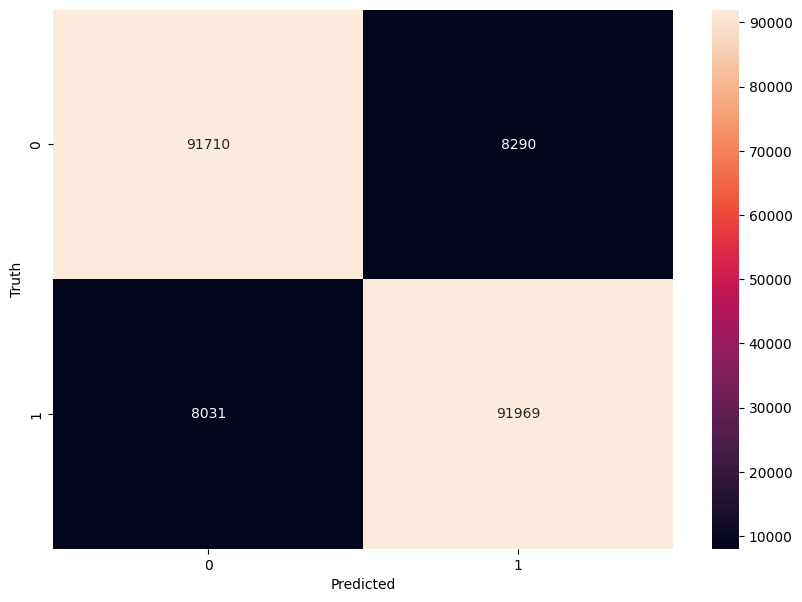

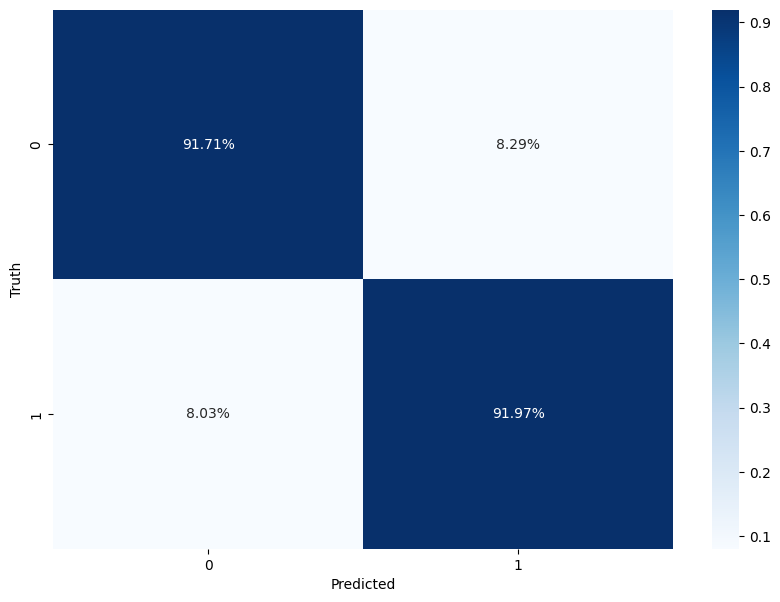

In [7]:
model = load_model('trainedModel.h5')
y_pred = model.predict(X_test_scaled).ravel()

cm = confusion_matrix(y_test, y_pred.round())

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [8]:
cm = confusion_matrix(y_test, y_pred.round())

TN, FP, FN, TP = cm.ravel()

print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")

True Positives: 91969
False Positives: 8290
True Negatives: 91710
False Negatives: 8031


In [10]:
from sklearn.metrics import classification_report

# Assuming y_true are your true labels and y_pred are the predicted labels
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92    100000
         1.0       0.92      0.92      0.92    100000

    accuracy                           0.92    200000
   macro avg       0.92      0.92      0.92    200000
weighted avg       0.92      0.92      0.92    200000



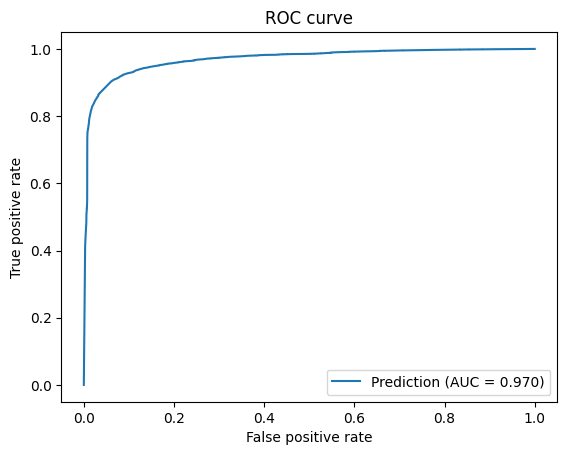

In [43]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = auc(fpr,tpr)

line = plt.plot(fpr, tpr, label='Prediction (AUC = {:.3f})'.format(auc))
yvalues = line[0].get_ydata()
xvalues = line[0].get_xdata()
idx = np.abs(xvalues - 0.01).argmin()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()